In [38]:
import librosa
import numpy as np
import os
import matplotlib.pyplot as plt

In [39]:
AUDIO_FILE_PATH = '/kaggle/input/audio-shots/shot.wav'

INTERVAL_DURATION_SEC = 1.0 

FREQ_MIN_HZ = 300 
FREQ_MAX_HZ = 4000 

ENERGY_THRESHOLD = 600000

In [40]:
AUDIO_FILE_PATH

'/kaggle/input/audio-shots/shot.wav'

In [41]:
def get_band_energy(segment, rate, f_min, f_max):
    if len(segment) == 0:
        return 0.0

    num_samples = len(segment)
    
    fft_coeffs = np.fft.rfft(segment)
    frequencies = np.fft.rfftfreq(num_samples, d=1./rate)
    
    amplitudes = np.abs(fft_coeffs)

    idx_start_freq = -1
    idx_end_freq = -1

    for i in range(len(frequencies)):
        if frequencies[i] >= f_min and idx_start_freq == -1:
            idx_start_freq = i
        if frequencies[i] <= f_max: 
            idx_end_freq = i
            
    if idx_start_freq == -1 or idx_end_freq == -1 or idx_start_freq > idx_end_freq:
        return 0.0

    energy_val = np.sum(amplitudes[idx_start_freq : idx_end_freq + 1]**2)
    
    return energy_val

def analyze_shooting_audio():
    print(f"Загружаю аудио: {AUDIO_FILE_PATH}")
    
    if not os.path.exists(AUDIO_FILE_PATH):
        print(f"ОШИБКА: Не могу найти файл {AUDIO_FILE_PATH}")
        return

    try:
        audio, sample_rate = librosa.load(AUDIO_FILE_PATH, sr=None)
        print(f"Аудио загружено: частота {sample_rate} Гц, длина {len(audio)/sample_rate:.2f} сек.")
    except Exception as e:
        print(f"Ошибка при загрузке файла: {e}")
        return

    # Длина интервала в сэмплах
    samples_in_interval = int(INTERVAL_DURATION_SEC * sample_rate)
    print(f"Каждый интервал будет по {samples_in_interval} сэмплов.")

    # Сколько всего интервалов получится
    num_total_intervals = len(audio) // samples_in_interval

    print(f"\nАнализирую файл...")
    print(f"Ищу энергию в диапазоне: {FREQ_MIN_HZ} - {FREQ_MAX_HZ} Гц")
    print(f"Текущий порог для выстрела: {ENERGY_THRESHOLD}")
    print("---------------------------------------------------------")

    found_shot_intervals = []
    all_interval_energies = [] # Сюда соберем все энергии для графика

    for i in range(num_total_intervals):
        start = i * samples_in_interval
        end = start + samples_in_interval
        current_segment = audio[start:end]

        # Считаем энергию
        current_energy = get_band_energy(current_segment, sample_rate, FREQ_MIN_HZ, FREQ_MAX_HZ)
        all_interval_energies.append(current_energy)

        time_s = start / sample_rate
        time_e = end / sample_rate

        # Решаем, был ли выстрел
        is_this_a_shot = current_energy > ENERGY_THRESHOLD
        
        result_message = "ДА, ВЫСТРЕЛ!" if is_this_a_shot else "нет, не выстрел."
        print(f"Интервал #{i+1:02d} ({time_s:05.1f}с - {time_e:05.1f}с): Энергия = {current_energy:10.2f} --> {result_message}")

        if is_this_a_shot:
            found_shot_intervals.append(i + 1)

    print("---------------------------------------------------------")
    if found_shot_intervals:
        print(f"Выстрелы (по текущему порогу) найдены в интервалах: {found_shot_intervals}")
    else:
        print("С таким порогом выстрелов не найдено.")

    plt.figure(figsize=(15, 7))
    interval_numbers = np.arange(1, num_total_intervals + 1)
    plt.plot(interval_numbers, all_interval_energies, marker='o', linestyle='--', color='green', label='Энергия интервала')
    plt.axhline(y=ENERGY_THRESHOLD, color='red', linestyle=':', linewidth=2, label=f'Установленный порог = {ENERGY_THRESHOLD}')
    plt.title('Энергия аудио в заданном диапазоне частот по 1-секундным интервалам')
    plt.xlabel('Номер интервала')
    plt.ylabel('Рассчитанная энергия')
    plt.xticks(interval_numbers) 
    plt.grid(True, linestyle='-.', alpha=0.7)
    plt.show()
    

    if all_interval_energies: 
        print(f"Для справки: Мин.энергия={min(all_interval_energies):.2f}, Макс.энергия={max(all_interval_energies):.2f}, Средняя энергия={np.mean(all_interval_energies):.2f}")

Загружаю аудио: /kaggle/input/audio-shots/shot.wav
Аудио загружено: частота 16000 Гц, длина 15.89 сек.
Каждый интервал будет по 16000 сэмплов.

Анализирую файл...
Ищу энергию в диапазоне: 300 - 4000 Гц
Текущий порог для выстрела: 600000
---------------------------------------------------------
Интервал #01 (000.0с - 001.0с): Энергия =  192201.25 --> нет, не выстрел.
Интервал #02 (001.0с - 002.0с): Энергия =  282200.47 --> нет, не выстрел.
Интервал #03 (002.0с - 003.0с): Энергия =  158547.16 --> нет, не выстрел.
Интервал #04 (003.0с - 004.0с): Энергия =   99063.41 --> нет, не выстрел.
Интервал #05 (004.0с - 005.0с): Энергия =  193426.06 --> нет, не выстрел.
Интервал #06 (005.0с - 006.0с): Энергия =  196265.38 --> нет, не выстрел.
Интервал #07 (006.0с - 007.0с): Энергия =  110691.82 --> нет, не выстрел.
Интервал #08 (007.0с - 008.0с): Энергия =  124847.53 --> нет, не выстрел.
Интервал #09 (008.0с - 009.0с): Энергия =   10231.53 --> нет, не выстрел.
Интервал #10 (009.0с - 010.0с): Энергия

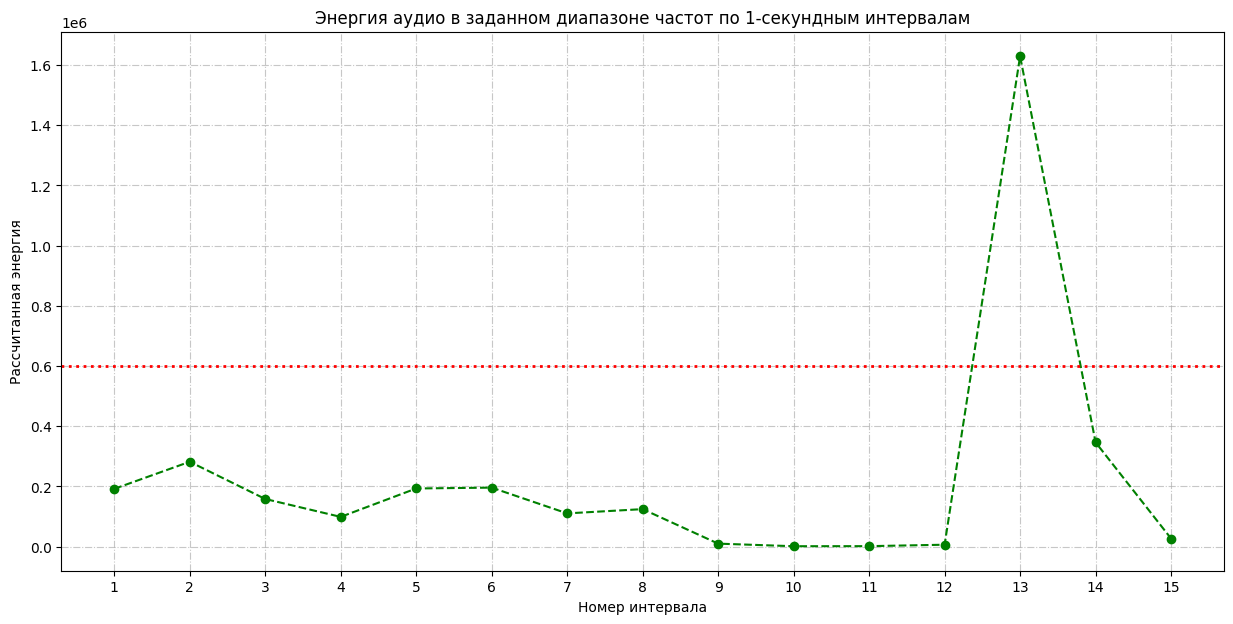

Для справки: Мин.энергия=1642.66, Макс.энергия=1629054.88, Средняя энергия=225369.92


In [42]:
analyze_shooting_audio()